In [14]:
import numpy as np
import h5py
import math
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os, sys
from BaselineRemoval import BaselineRemoval
import scipy
import itertools

In [15]:
class HiddenPrints:
	def __enter__(self):
		self._original_stdout = sys.stdout
		sys.stdout = open(os.devnull, 'w')

In [16]:
def __exit__(self, exc_type, exc_val, exc_tb):
	sys.stdout.close()
	sys.stdout = self._original_stdout

In [17]:
def pca_func(data, n_components):
    
    # original method
    #pca = PCA(n_components=n_components)
    #pca.fit(data)
    #out = pca.transform(data)

    
    # fishtank-compatible method
    # Subtract the mean from the data to center it
    mean = np.mean(data, axis=0)
    data_centered = data - mean

    # Compute the covariance matrix
    cov = np.cov(data_centered, rowvar=False)

    # Compute the eigenvectors and eigenvalues of the covariance matrix
    eigvals, eigvecs = np.linalg.eig(cov)

    # Transform the data into the new coordinate system defined by the eigenvectors
    out = np.dot(data_centered, eigvecs)

    return out

In [18]:
def dbscan(X, eps, min_samples):
    # Initialize variables
    labels = np.zeros(X.shape[0])
    cluster = 0

    # Compute distances between points
    dists = np.sqrt(((X[:, np.newaxis] - X) ** 2).sum(axis=2))

    # Iterate over each point
    for i in range(X.shape[0]):
        # If point already visited, continue
        if labels[i] != 0:
            continue

        # Find neighboring points
        neighbors = np.where(dists[i] <= eps)[0]

        # If not enough neighboring points, label as noise
        if len(neighbors) < min_samples:
            labels[i] = -1
            continue

        # Expand cluster
        cluster += 1
        labels[i] = cluster

        while len(neighbors) > 0:
            j = neighbors[0]
            if labels[j] == -1:
                labels[j] = cluster
            elif labels[j] == 0:
                labels[j] = cluster
                new_neighbors = np.where(dists[j] <= eps)[0]
                if len(new_neighbors) >= min_samples:
                    neighbors = np.concatenate((neighbors, new_neighbors))
            neighbors = neighbors[1:]

    return labels

In [19]:
def remove_outliers(xset, yset, zset, eset, threshold):
	#Uses DBSCAN to find and remove outliers in 3D data
	# NEEDS ALTERNATE METHOD FOR FISHTANK COMPATIBILITY
	data = np.array([xset.T, yset.T, zset.T]).T

	# STANDARD METHOD
	#DBSCAN_cluster = DBSCAN(eps=7, min_samples=10).fit(data)
	#out_of_cluster_index = np.where(DBSCAN_cluster.labels_==-1)

	# FISHTANK METHOD
	labels = dbscan(data, eps=7, min_samples=10)
	out_of_cluster_index = np.where(labels==-1)

	del data
	rev = out_of_cluster_index[0][::-1]
	
	for i in rev:
		xset = np.delete(xset, i)
		yset = np.delete(yset, i)
		zset = np.delete(zset, i)
		eset = np.delete(eset, i)
	if len(xset) <= threshold:
		veto = True
	else:
		veto = False
	
	# testing
	veto = False

	return xset, yset, zset, eset, veto

In [20]:
print('Veto on Length @ 70 mm')
print('Veto on Integrated Charge @ 800k')
def track_len(xset, yset, zset):
    """
    Uses PCA to find the length of a track
    """
    veto_on_length = False
 
    # Form data matrix
    data = np.concatenate((xset[:, np.newaxis], 
                           yset[:, np.newaxis], 
                           zset[:, np.newaxis]), 
                           axis=1)

    # Use PCA to find track length
    principalComponents = pca_func(data, 3)

    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    
    track_len = 2.35*principalDf.std()[0]
    track_width = 2.35*principalDf.std()[1]
    track_depth = 2.35*principalDf.std()[2]
    #if track_len > 70:
    #    veto_on_length = True
    
    return track_len, veto_on_length, track_width, track_depth

Veto on Length @ 70 mm
Veto on Integrated Charge @ 800k


In [21]:
def poly_baseline_removal(data, degree):
        # Compute the integrated signal
        integral = np.cumsum(data)
        # Fit a polynomial to the integrated signal
        p = np.polyfit(np.array(range(len(data))), integral, degree)
        # Evaluate the polynomial at each point in the signal
        baseline = np.polyval(p, np.array(range(len(data))))
        # Subtract the baseline from the signal
        corrected = data - baseline
        # Return the corrected signal
        return corrected

In [22]:
def main(h5file, threshold):
    """
    This functions does the following: 
    - Converts h5 files into ndarrays. 
    - Removes outliers.
    - Calls PCA to return track length.
    - Sums mesh signal to return energy.
    """
    # Converts h5 files into ndarrays, and output each event dataset as a separte list
    num_events = int(len(list(h5file.keys()))/2) 
    
    len_list = []
    width_list = []
    depth_list = []
    good_events = []
    tot_energy = []
    tracemax_list = []
    tracedev_list = []
    pads_list = []
    
    skipped_events = 0
    veto_events = 0
    
    #pbar = tqdm(total=num_events+1)
    for i in range(0, num_events):
        str_event = f"Event_[{i}]"
        
        # Apply pad threshold
        event = np.array(h5file[str_event][:])
        if len(event) <= threshold:
            skipped_events += 1
            #pbar.update(n=1)
            continue
            
        # Make copy of datasets
        dset_0_copyx = event['x']
        dset_0_copyy = event['y'] 
        dset_0_copyz = event['z'] - min(event['z'])
        dset_0_copye = event['A']
        
        # Apply veto condition
        R = 36                           # Radius of the pad plane
        r = np.sqrt(dset_0_copyx**2 + dset_0_copyy**2)
        statements = np.greater(r, R)    # Check if any point lies outside of R
      
        if np.any(statements) == True:
            veto_events += 1
            #pbar.update(n=1)
            continue
        
        
        # Call remove_outliers to get dataset w/ outliers removed
        dset_0_copyx, dset_0_copyy, dset_0_copyz, dset_0_copye, veto = remove_outliers(dset_0_copyx, dset_0_copyy, dset_0_copyz, dset_0_copye, threshold)
        veto = False
        if veto == True:
            skipped_events += 1
            #pbar.update(n=1)
            continue

        
        # Call track_len() to create lists of all track lengths
        length, veto_on_length, width, depth = track_len(dset_0_copyx, dset_0_copyy, dset_0_copyz)
        if veto_on_length == True:
            veto_events += 1
            #pbar.update(n=1)
            continue

        
       	str_trace = f"Trace_[{i}]"
        trace = np.array(h5file[str_trace][:])
        max_val = np.argmax(trace)
        low_bound = max_val - 75
        if low_bound < 0:
            low_bound = 5
        upper_bound = max_val + 75
        if upper_bound > 511:
            upper_bound = 506
        trace = trace[low_bound:upper_bound]

        polynomial_degree=2
        # STANDARD METHOD
        baseObj=BaselineRemoval(trace)
        trace=baseObj.IModPoly(polynomial_degree)

        # FISHTANK METHOD
        # determine the width of the peak in the trace and the location of the peak
        peakloc = np.argmax(trace)
        
        peakwidth1 = 0
        peakwidth2 = 0

        i = peakloc
        while trace[i] > np.min(trace) + np.std(trace):
            peakwidth1 += 1
            i += 1
        i = peakloc
        while trace[i] > np.min(trace) + np.std(trace):
            peakwidth2 += 1
            i -= 1

        # calculate the average of the trace outside of the peakwidth window on either side of the peak
        baseline = np.mean(np.concatenate((trace[:peakloc-peakwidth2], trace[peakloc+peakwidth1:])))
        # subtract the baseline from the trace
        trace = trace - baseline

        #if np.sum(trace) > 800000:
        #    veto_events += 1
        #    pbar.update(n=1)
        #    continue

        len_list.append(length)
        width_list.append(width)
        tot_energy.append(np.sum(trace))
        tracemax_list.append(np.max(trace))
        tracedev_list.append(np.std(trace))
        pads_list.append(len(dset_0_copyx))

        # Track event number of good events
        good_events.append(i)  
        #pbar.update(n=1)

    return (tot_energy, skipped_events, veto_events, good_events, len_list, width_list, tracemax_list, tracedev_list, pads_list)

In [23]:
# assign directory
directory = "C:/Users/Adam/OneDrive - Tenundra, Inc/Desktop/Programming/GADGET2/simOutput/"

output_df = pd.DataFrame(columns=['file','event','length', 'width', 'tracesum', 'tracemax', 'tracedev', 'padnum'])

file_names = []
# iterate over files in directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        if f[-3:] == '.h5':
            print(f)
            file_names.append(filename)
            h5f = h5py.File(directory+filename, 'r')
            (tot_energy, skipped_events, veto_events, good_events, len_list, width_list, tracemax_list, tracedev_list, pads_list) = main(h5file=h5f, threshold=15)
            for event in range(len(tot_energy)):
                output_df = output_df.append({'file' : filename, 
                                              'event' : event, 
                                              'length' : len_list[event], 
                                              'width' : width_list[event], 
                                              'tracesum' : tot_energy[event], 
                                              'tracemax' : tracemax_list[event], 
                                              'tracedev' : tracedev_list[event], 
                                              'padnum' : pads_list[event]}
                                             ,ignore_index = True)

C:/Users/Adam/OneDrive - Tenundra, Inc/Desktop/Programming/GADGET2/simOutput/273_800p.h5


In [24]:
for file in file_names:
    print(file)
    print('length:\t', output_df[output_df['file'] == file]['length'].mean(),'\t', output_df[output_df['file'] == file]['length'].std())
    print('width:\t', output_df[output_df['file'] == file]['width'].mean(),'\t', output_df[output_df['file'] == file]['width'].std())
    print('tracesum:\t', output_df[output_df['file'] == file]['tracesum'].mean(),'\t', output_df[output_df['file'] == file]['tracesum'].std())
    print('tracemax:\t', output_df[output_df['file'] == file]['tracemax'].mean(),'\t', output_df[output_df['file'] == file]['tracemax'].std())
    print('tracedev:\t', output_df[output_df['file'] == file]['tracedev'].mean(),'\t', output_df[output_df['file'] == file]['tracedev'].std())
    print('padnum:\t', output_df[output_df['file'] == file]['padnum'].mean(),'\t', output_df[output_df['file'] == file]['padnum'].std())
    print()

273_800p.h5
length:	 13.47481712935178 	 1.1701253051807101
width:	 4.399283145288104 	 2.10221647449801
tracesum:	 146867.14958406464 	 3289.2477416384686
tracemax:	 17205.45683072563 	 3817.6791802841067
tracedev:	 3396.80817140803 	 395.6029936835511
padnum:	 28.71005917159763 	 7.452086120815371



In [25]:
output_df.to_csv('event summary.csv', index=False)

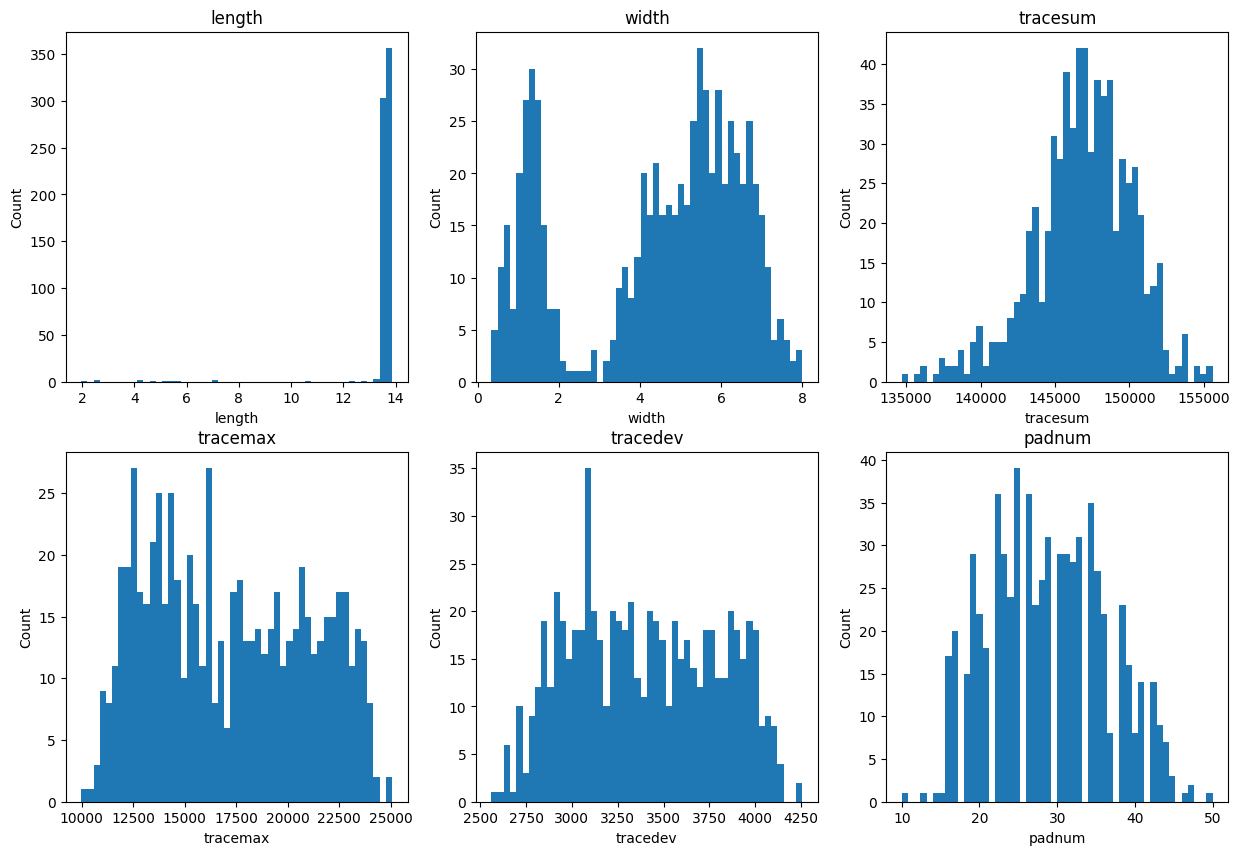

In [26]:
# Plot a histogram of all track attributes
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for ax, col in zip(axs.flatten(), output_df.columns[2:]):
    ax.hist(output_df[col], bins=50)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')